In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
torch.cuda.set_device(1)

### MNIST SGD

In [3]:
path = Path('data/mnist')

In [4]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [5]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

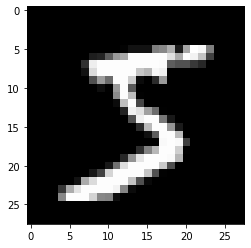

In [6]:
plt.imshow(x_train[0].reshape(28,28),cmap="gray")
x_train.shape

In [7]:
x_train,y_train,x_valid,y_valid=map(torch.tensor,(x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape,y_train.min(),y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [8]:
bs=128
train_ds=TensorDataset(x_train,y_train)
valid_ds= TensorDataset(x_valid,y_valid)
data=DataBunch.create(train_ds,valid_ds,bs=bs)

In [9]:
x,y=next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([128, 784]), torch.Size([128]))

In [10]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [11]:
model = Mnist_Logistic().cuda()

In [12]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [14]:
model(x).shape

torch.Size([128, 10])

In [15]:
[p.shape for p in model.parameters()] #weight and bias matrices

[torch.Size([10, 784]), torch.Size([10])]

In [16]:
lr=2e-2

In [17]:
loss_func=nn.CrossEntropyLoss()

In [18]:
def update(x,y,lr):
    wd=1e-5
    y_hat=model(x)
    w2=0.
    for p in model.parameters():w2+=(p**2).sum()
    #add to regular loss
    loss=loss_func(y_hat,y)+w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [19]:
losses = [update(x,y,lr) for x,y in data.train_dl]

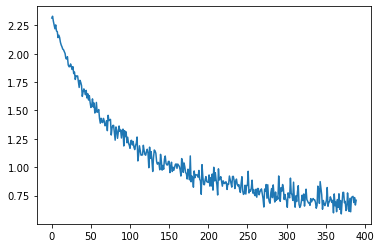

In [20]:
plt.plot(losses)

In [22]:
#Neural Network
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [23]:
model=Mnist_NN().cuda()

In [24]:
losses = [update(x,y,lr) for x,y in data.train_dl]

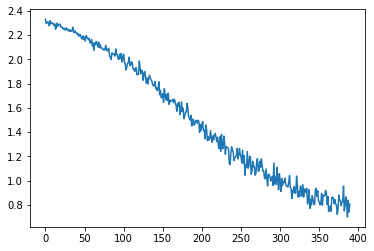

In [25]:
plt.plot(losses);


In [26]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [27]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

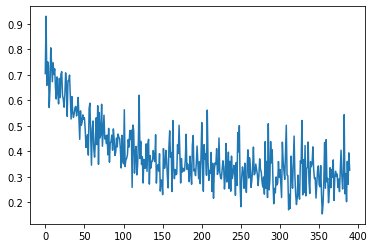

In [28]:
plt.plot(losses);

In [29]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


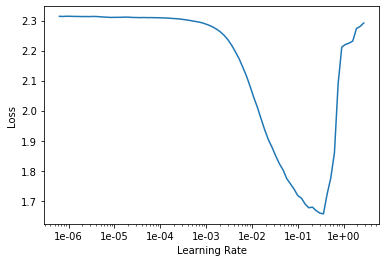

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.174712,0.152064,0.957100,00:03


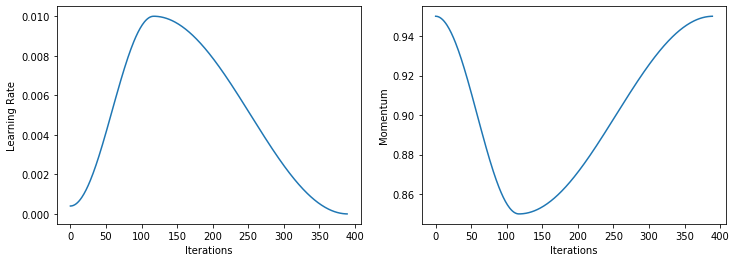

In [32]:
learn.recorder.plot_lr(show_moms=True)

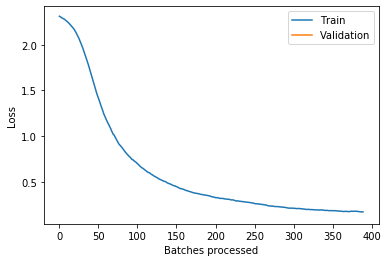

In [33]:
learn.recorder.plot_losses()
